In [1]:
import pandas as pd
import numpy as np
import os
import getpass
import re
import nltk
import tqdm
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import swifter
import matplotlib as plt
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras import optimizers
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [2]:
df = pd.read_csv("Merged_Finall.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by="Date")

In [3]:
df["prev_close"] = df["Close"].shift(+1)
df["prev2_close"] = df["Close"].shift(+2)
df["prev3_close"] = df["Close"].shift(+3)
df["prev4_close"] = df["Close"].shift(+4)
df["prev5_close"] = df["Close"].shift(+5)
df = df.dropna()
df

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,timestamp,FinalScore,prev_close,prev2_close,prev3_close,prev4_close,prev5_close
5,6,Bitcoin,BTC,2013-05-04,115.000000,92.500000,98.099998,112.500000,0.000000e+00,1.250317e+09,2013-05-04,0.945516,97.750000,105.209999,116.989998,139.000000,144.539993
6,7,Bitcoin,BTC,2013-05-05,118.800003,107.142998,112.900002,115.910004,0.000000e+00,1.288693e+09,2013-05-05,1.141080,112.500000,97.750000,105.209999,116.989998,139.000000
7,8,Bitcoin,BTC,2013-05-06,124.663002,106.639999,115.980003,112.300003,0.000000e+00,1.249023e+09,2013-05-06,1.052813,115.910004,112.500000,97.750000,105.209999,116.989998
8,9,Bitcoin,BTC,2013-05-07,113.444000,97.699997,112.250000,111.500000,0.000000e+00,1.240594e+09,2013-05-07,1.001711,112.300003,115.910004,112.500000,97.750000,105.209999
9,10,Bitcoin,BTC,2013-05-08,115.779999,109.599998,109.599998,113.566002,0.000000e+00,1.264049e+09,2013-05-08,0.818127,111.500000,112.300003,115.910004,112.500000,97.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,2396,Bitcoin,BTC,2019-11-19,8408.516128,8099.963369,8305.134291,8206.145918,2.108361e+10,1.481784e+11,2019-11-19,266.234714,8309.285983,8577.975782,8550.760557,8491.992012,8708.095095
2396,2397,Bitcoin,BTC,2019-11-20,8237.239874,8010.511901,8203.613180,8027.268243,2.076430e+10,1.449627e+11,2019-11-20,10.221575,8206.145918,8309.285983,8577.975782,8550.760557,8491.992012
2397,2398,Bitcoin,BTC,2019-11-21,8110.098131,7597.381608,8023.644687,7642.749945,2.251424e+10,1.380319e+11,2019-11-21,-8503.435071,8027.268243,8206.145918,8309.285983,8577.975782,8550.760557
2398,2399,Bitcoin,BTC,2019-11-22,7697.382714,6936.706599,7643.569425,7296.577568,3.424232e+10,1.317918e+11,2019-11-22,15.649639,7642.749945,8027.268243,8206.145918,8309.285983,8577.975782


In [4]:
seen_df= df[:int(len(df) * 0.80)]
unseen_df = df[int(len(df) * 0.80):]
print(f"Records in seen Dataframe -> {len(seen_df)} and records in unseen Dataframe -> {len(unseen_df)}")

Records in seen Dataframe -> 1916 and records in unseen Dataframe -> 479


In [5]:
split_date = '2018-08-01'
df_train = seen_df.loc[seen_df.Date <= split_date].copy()
df_test = seen_df.loc[seen_df.Date > split_date].copy()

In [6]:
X_train = df_train[["prev_close", "prev2_close", "prev3_close", "prev4_close", "prev5_close", "FinalScore", "Volume"]]
y_train = df_train["Close"]

X_test = df_train[["prev_close", "prev2_close", "prev3_close", "prev4_close", "prev5_close", "FinalScore", "Volume"]]
y_test = df_train["Close"]

unseen_X_test = unseen_df[["prev_close", "prev2_close", "prev3_close", "prev4_close", "prev5_close", "FinalScore", "Volume"]]
unseen_y_test = unseen_df["Close"]

In [7]:
reg = xgb.XGBRegressor(n_estimators=10000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:2802.87524	validation_1-rmse:2802.87524
[1]	validation_0-rmse:1991.35559	validation_1-rmse:1991.35559
[2]	validation_0-rmse:1419.99951	validation_1-rmse:1419.99939
[3]	validation_0-rmse:1018.26721	validation_1-rmse:1018.26715
[4]	validation_0-rmse:737.22076	validation_1-rmse:737.22076
[5]	validation_0-rmse:541.70923	validation_1-rmse:541.70923
[6]	validation_0-rmse:408.09766	validation_1-rmse:408.09763
[7]	validation_0-rmse:312.45444	validation_1-rmse:312.45444
[8]	validation_0-rmse:245.66580	validation_1-rmse:245.66582
[9]	validation_0-rmse:196.62886	validation_1-rmse:196.62886
[10]	validation_0-rmse:163.33975	validation_1-rmse:163.33975
[11]	validation_0-rmse:138.21176	validation_1-rmse:138.21176
[12]	validation_0-rmse:121.02419	validation_1-rmse:121.02419
[13]	validation_0-rmse:108.09302	validation_1-rmse:108.09303
[14]	validation_0-rmse:97.55016	validation_1-rmse:97.55016
[15]	validation_0-rmse:87.96639	validation_1-rmse:87.96639
[16]	validation_0-rmse:81.2302

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [8]:
unseen_df['Prediction'] = reg.predict(unseen_X_test)

/tmp/ipykernel_912573/371211560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unseen_df['Prediction'] = reg.predict(unseen_X_test)


In [9]:
unseen_df = unseen_df[["Date", "Close", "Prediction"]]
unseen_df

,Date,Close,Prediction
1921,2018-08-02,7567.150000,7846.352051
1922,2018-08-03,7434.390000,7405.397461
1923,2018-08-04,7032.850000,7307.985840
1924,2018-08-05,7068.480000,7045.562500
1925,2018-08-06,6951.800000,7209.834961
...,...,...,...
2395,2019-11-19,8206.145918,8524.333008
2396,2019-11-20,8027.268243,8260.804688
2397,2019-11-21,7642.749945,8119.801758
2398,2019-11-22,7296.577568,8394.787109


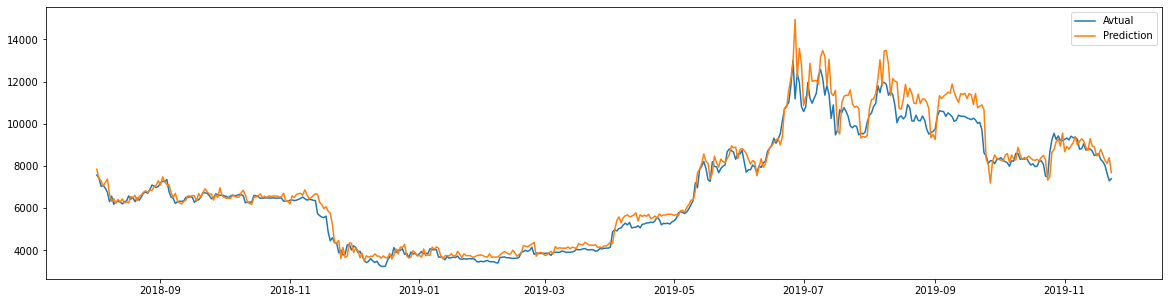

In [10]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(unseen_df["Date"], unseen_df["Close"], label = "Avtual")
plt.plot(unseen_df["Date"], unseen_df["Prediction"], label = "Prediction")
plt.legend()

In [11]:
merged_df = unseen_df[["Date", "Close", "Prediction"]]
merged_df.columns = ["Date", "Actual", "Prediction"]
merged_df

,Date,Actual,Prediction
1921,2018-08-02,7567.150000,7846.352051
1922,2018-08-03,7434.390000,7405.397461
1923,2018-08-04,7032.850000,7307.985840
1924,2018-08-05,7068.480000,7045.562500
1925,2018-08-06,6951.800000,7209.834961
...,...,...,...
2395,2019-11-19,8206.145918,8524.333008
2396,2019-11-20,8027.268243,8260.804688
2397,2019-11-21,7642.749945,8119.801758
2398,2019-11-22,7296.577568,8394.787109


In [12]:
merged_df["Actual_prev"] = merged_df["Actual"].shift(+1)
merged_df["Pred_prev"] = merged_df["Prediction"].shift(+1)
merged_df = merged_df.dropna()

In [13]:
merged_df

,Date,Actual,Prediction,Actual_prev,Pred_prev
1922,2018-08-03,7434.390000,7405.397461,7567.150000,7846.352051
1923,2018-08-04,7032.850000,7307.985840,7434.390000,7405.397461
1924,2018-08-05,7068.480000,7045.562500,7032.850000,7307.985840
1925,2018-08-06,6951.800000,7209.834961,7068.480000,7045.562500
1926,2018-08-07,6753.120000,7385.312988,6951.800000,7209.834961
...,...,...,...,...,...
2395,2019-11-19,8206.145918,8524.333008,8309.285983,8787.867188
2396,2019-11-20,8027.268243,8260.804688,8206.145918,8524.333008
2397,2019-11-21,7642.749945,8119.801758,8027.268243,8260.804688
2398,2019-11-22,7296.577568,8394.787109,7642.749945,8119.801758


In [14]:
merged_df['Actual_target'] = merged_df[['Actual','Actual_prev']].apply(lambda x: 1 if x.Actual > x.Actual_prev else 0, axis=1)
merged_df['Pred_target'] = merged_df[['Prediction','Pred_prev']].apply(lambda x: 1 if x.Prediction > x.Pred_prev else 0, axis=1)

/tmp/ipykernel_912573/2833640580.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Actual_target'] = merged_df[['Actual','Actual_prev']].apply(lambda x: 1 if x.Actual > x.Actual_prev else 0, axis=1)
/tmp/ipykernel_912573/2833640580.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Pred_target'] = merged_df[['Prediction','Pred_prev']].apply(lambda x: 1 if x.Prediction > x.Pred_prev else 0, axis=1)


In [15]:
merged_df

,Date,Actual,Prediction,Actual_prev,Pred_prev,Actual_target,Pred_target
1922,2018-08-03,7434.390000,7405.397461,7567.150000,7846.352051,0,0
1923,2018-08-04,7032.850000,7307.985840,7434.390000,7405.397461,0,0
1924,2018-08-05,7068.480000,7045.562500,7032.850000,7307.985840,1,0
1925,2018-08-06,6951.800000,7209.834961,7068.480000,7045.562500,0,1
1926,2018-08-07,6753.120000,7385.312988,6951.800000,7209.834961,0,1
...,...,...,...,...,...,...,...
2395,2019-11-19,8206.145918,8524.333008,8309.285983,8787.867188,0,0
2396,2019-11-20,8027.268243,8260.804688,8206.145918,8524.333008,0,0
2397,2019-11-21,7642.749945,8119.801758,8027.268243,8260.804688,0,0
2398,2019-11-22,7296.577568,8394.787109,7642.749945,8119.801758,0,1


In [16]:
act = list(merged_df["Actual_target"])
pred = list(merged_df["Pred_target"])

In [17]:
hit = 0
miss = 0
for i in range(len(act)):
    if act[i] == pred[i]:
        hit+=1
    else:
        miss+=1
print(f"total hits are {hit} and total misses are {miss}")

total hits are 246 and total misses are 232
